# Ridge, LASSO, Root-LASSO Regression

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from cvxpy import *
%matplotlib inline

## Simulating the AR model
simulate 2nd order AR model: <latex>$y_{k} = a_1y_{k-1}+a_2y_{k-2}+w_{k}$

In [2]:
def systemSimulation(N,a1,a2,noisePwr,signalPwr):
    '''
    @N: int, length of the sequence
    @a1: float, param 1
    @a2: float, param 2
    @noisePwr: float, power of noise
    w: AWGN noise
    '''
    y = np.zeros(N)
    y[0:2] = np.array([5,10])
    for i in range(N-2):
        y[i+2] = a1*y[i+1]+a2*y[i]+np.random.randn()*np.sqrt(noisePwr)
    return y

In [186]:
def biasVarCalculation(estimatedParam, realParam):
    bias = realParam - estimatedParam
    vari = np.var(estimatedParam)
    return bias,vari

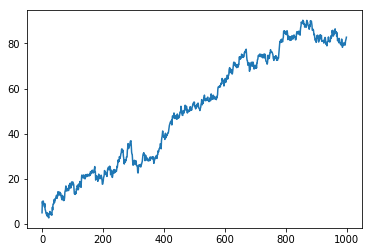

In [187]:
sysParam = np.array([0.9,0.1])
y = systemSimulation(1000,a1=sysParam[0],a2=sysParam[1], noisePwr=1,signalPwr=100)
plt.plot(y)

## Classical Least Square Regression

In [188]:
def LeastSquareRegression(y):
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T)@phi@y[2:]
    return estimatedParam

In [197]:
LSEstimation = LeastSquareRegression(y)
# print(LSEstimation)
biasLS, varLS = biasVarCalculation(LSEstimation,sysParam)
print(sum(biasLS**2),varLS)

0.00470477132228 0.201151389145


## Ridge Regression

In [190]:
def RidgeRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for Ridge penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    estimatedParam = np.linalg.inv(phi@phi.T+lambdaParam*np.eye(2))@phi@y[2:]
    return estimatedParam

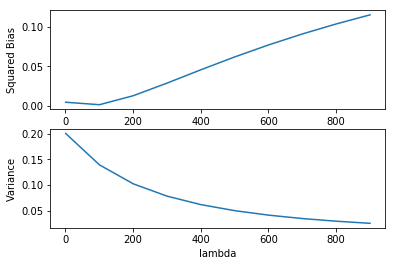

In [205]:
biasSquareRidge = []
varRidge = []
for lambdaParam in range(10):
    RidgeEstimation = RidgeRegression(y,lambdaParam*100+1)
#     print(RidgeEstimation)
    biasRidgeTemp, varRidgeTemp = biasVarCalculation(RidgeEstimation,sysParam)
    biasSquareRidge.append(np.sum(biasRidgeTemp**2))
    varRidge.append(varRidgeTemp)
plt.figure(1)
plt.subplot(211)
plt.plot(np.arange(10)*100+1,biasSquareRidge)
plt.xlabel('lambda')
plt.ylabel('Squared Bias')
plt.subplot(212)
plt.plot(np.arange(10)*100+1,varRidge)
plt.xlabel('lambda')
plt.ylabel('Variance')

## LASSO Regression

In [224]:
def LassoRegression(y,lambdaParam):
    '''
    @lambdaParam: float, parameter for LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    LassoEstimation = Variable(2)
    objective = Minimize(sum_squares(y[2:] - phi.T@LassoEstimation)+lambdaParam*pnorm(LassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve(solver='CVXOPT')
    return LassoEstimation.value

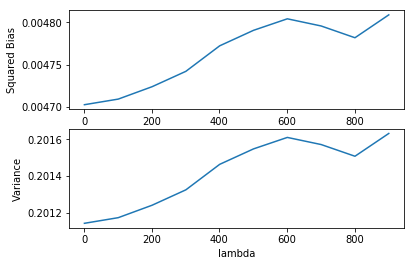

In [228]:
biasSquareLASSO = []
varLASSO = []
for lambdaParam in range(10):
    LassoEstimation = LassoRegression(y,lambdaParam*100+1)
#     print(LassoEstimation)
    biasLASSOTemp, varLASSOTemp = biasVarCalculation(LassoEstimation.T,sysParam)
    biasSquareLASSO.append(np.sum(np.array(biasLASSOTemp)**2))
    varLASSO.append(varLASSOTemp)
plt.figure(2)
plt.subplot(211)
plt.plot(np.arange(10)*100+1,biasSquareLASSO)
plt.xlabel('lambda')
plt.ylabel('Squared Bias')
plt.subplot(212)
plt.plot(np.arange(10)*100+1,varLASSO)
plt.xlabel('lambda')
plt.ylabel('Variance')

## Square Root LASSO Regression

In [133]:
def RootLassoRegression(y,muParam):
    '''
    @muParam: float, parameter for Square Root LASSO penality
    '''
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    n = np.sqrt(len(y))
    RootLassoEstimation = Variable(2)
    objective = Minimize(n*sum_squares(y[2:] - phi.T@RootLassoEstimation)+muParam*pnorm(RootLassoEstimation,1))
    prob = Problem(objective)
    result = prob.solve(solver='CVXOPT')
    return RootLassoEstimation.value

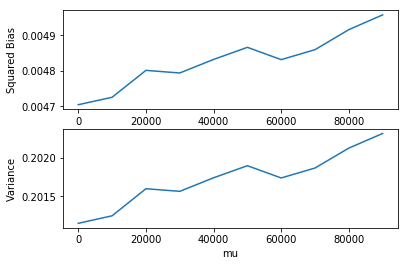

In [232]:
biasSquareSRLASSO = []
varSRLASSO = []
for muParam in range(10):
    RootLassoEstimation = RootLassoRegression(y,muParam*10000+1)
#     print(RootLassoEstimation)
    biasSRLASSOTemp, varSRLASSOTemp = biasVarCalculation(RootLassoEstimation.T,sysParam)
#     print(biasSRLASSO, varSRLASSO)
    biasSquareSRLASSO.append(np.sum(np.array(biasSRLASSOTemp)**2))
    varSRLASSO.append(varSRLASSOTemp)
plt.figure(3)
plt.subplot(211)
plt.plot(np.arange(10)*10000+1,biasSquareSRLASSO)
plt.xlabel('mu')
plt.ylabel('Squared Bias')
plt.subplot(212)
plt.plot(np.arange(10)*10000+1,varSRLASSO)
plt.xlabel('mu')
plt.ylabel('Variance')

## Elastic-Net Criterion

In [151]:
def ElasticNet(y,lambdaParam, alphaParam):
    '''
    @lambdaParam: positive float, parameter for Elastic Net penality
    @alphaParam: float (0-1)
    '''
    if lambdaParam < 0:
        print('Lambda negative')
        return None;
    if alphaParam >= 1 or alphaParam <=0:
        print('Alpha not in range(0,1)')
        return None;
    phi = sc.linalg.toeplitz(y)
    phi = phi[0:2,1:-1]
    n = np.sqrt(len(y))
    ElasticNetEstimation = Variable(2)
    objective = Minimize(n*sum_squares(y[2:] - phi.T@ElasticNetEstimation)+muParam*(alphaParam*pnorm(ElasticNetEstimation,1)+(1-alphaParam)*sum_squares(ElasticNetEstimation)))
    prob = Problem(objective)
    result = prob.solve(solver='CVXOPT')
    return ElasticNetEstimation.value

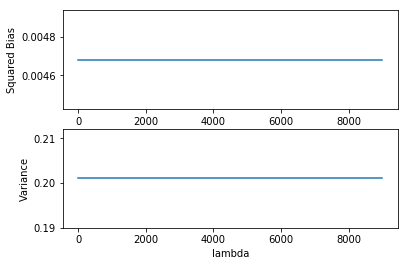

In [233]:
biasSquareENetLambda = []
varENetLambda = []
for lambdaParam in range(10):
    ElasticNetEstimation = ElasticNet(y,lambdaParam*1000,0.5)
    biasENTemp, varENTemp = biasVarCalculation(ElasticNetEstimation.T,sysParam)
#     print(biasEN, varEN)
    biasSquareENetLambda.append(np.sum(np.array(biasENTemp)**2))
    varENetLambda.append(varENTemp)
plt.figure(4)
plt.subplot(211)
plt.plot(np.arange(10)*1000+1,biasSquareENetLambda)
plt.xlabel('lambda')
plt.ylabel('Squared Bias')
plt.subplot(212)
plt.plot(np.arange(10)*1000+1,varENetLambda)
plt.xlabel('lambda')
plt.ylabel('Variance')

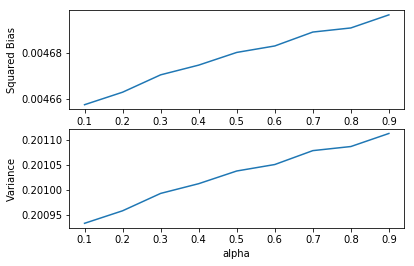

In [221]:
biasSquareENetAlpha = []
varENetAlpha = []
for alphaParam in range(9):
    ElasticNetEstimation = ElasticNet(y,1000,(alphaParam+1)/10)
    biasENTemp, varENTemp = biasVarCalculation(ElasticNetEstimation.T,sysParam)
    biasSquareENetAlpha.append(np.sum(np.array(biasENTemp)**2))
    varENetAlpha.append(varENTemp)
plt.figure(5)
plt.subplot(211)
plt.plot((np.arange(9)+1)/10,biasSquareENetAlpha)
plt.xlabel('alpha')
plt.ylabel('Squared Bias')
plt.subplot(212)
plt.plot((np.arange(9)+1)/10,varENetAlpha)
plt.xlabel('alpha')
plt.ylabel('Variance')    